In [1]:
from FLAI import data
from FLAI import causal_graph

In [2]:
import pandas as pd
df = pd.read_pickle('Data/titanic.pickle')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
flai_dataset = data.Data(df, transform=True)

In [4]:
flai_dataset.data.head(5)

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,0,3,108,1,2,1,523,146,3
1,1,1,190,0,2,1,596,81,1
2,1,3,353,0,1,1,669,146,3
3,1,1,272,0,2,1,49,55,3
4,0,3,15,1,1,1,472,146,3


In [5]:
flai_dataset.data

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,0,3,108,1,2,1,523,146,3
1,1,1,190,0,2,1,596,81,1
2,1,3,353,0,1,1,669,146,3
3,1,1,272,0,2,1,49,55,3
4,0,3,15,1,1,1,472,146,3
...,...,...,...,...,...,...,...,...,...
886,0,2,548,1,1,1,101,146,3
887,1,1,303,0,1,1,14,30,3
888,0,3,413,0,2,3,675,146,3
889,1,1,81,1,1,1,8,60,1


In [6]:
flai_graph = causal_graph.CausalGraph(flai_dataset)

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).


In [7]:
flai_graph.graph['model_edges']

[('Survived', 'Sex'),
 ('Pclass', 'Embarked'),
 ('Pclass', 'Survived'),
 ('Pclass', 'Sex'),
 ('Sex', 'Parch'),
 ('Parch', 'SibSp')]

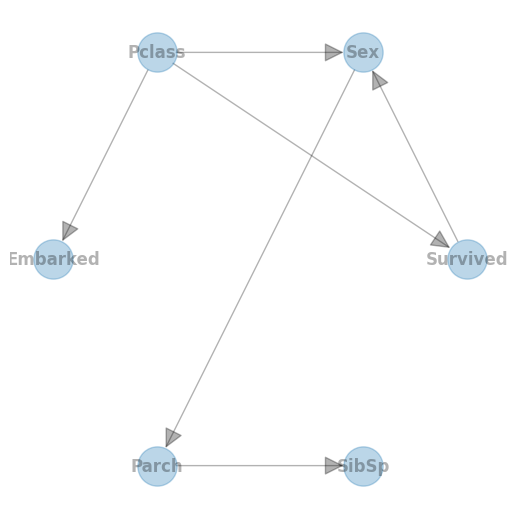

In [8]:
flai_graph.plot()

In [9]:
flai_graph.learn_cpd()

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).
[bnlearn] >Warning: Structure scoring could not be computed. DataFrame issues (?)


In [10]:
flai_graph.graph['model_edges']

[('Survived', 'Sex'),
 ('Sex', 'Parch'),
 ('Pclass', 'Survived'),
 ('Pclass', 'Sex'),
 ('Pclass', 'Embarked'),
 ('Parch', 'SibSp')]

In [11]:
CPDs = flai_graph.get_CPDs()

In [12]:
CPDs['Survived']

,Survived,Pclass,p
0,0,0,0.449029
1,0,1,0.509665
2,0,2,0.653457
3,1,0,0.550971
4,1,1,0.490335
5,1,2,0.346543


In [13]:
from pgmpy.inference import CausalInference
infer = CausalInference(flai_graph.graph['model'],flai_graph.flai_dataset.data.columns)
q = infer.query(variables=['Survived'], evidence={'Pclass':3,
                                'Embarked':1,
                                'Sex':1,
                                'SibSp':5,
                                'Parch':2})
print(q.scope())
print(q.values)

['Survived']
[0.74626866 0.25373134]


In [14]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(flai_graph.graph['model'])
q = infer.query(variables=['Survived'], evidence={'Pclass':3,
                                'Embarked':1,
                                'Sex':1,
                                'SibSp':5,
                                'Parch':2})
print(q.scope())
print(q.values)

['Survived']
[0.74626866 0.25373134]


In [15]:
flai_dataset_fair = flai_graph.generate_dataset(n_samples = 1000, methodtype = 'bayes')

In [16]:
flai_dataset_fair.data

,Survived,Sex,Pclass,Embarked,Parch,SibSp
0,0,1,1,1,2,5
1,1,1,3,3,2,0
2,1,0,3,0,2,2
3,0,1,3,3,2,3
4,0,0,1,3,1,1
...,...,...,...,...,...,...
995,0,0,2,0,2,4
996,0,0,2,3,3,4
997,1,0,3,3,1,1
998,0,0,3,3,3,1


In [17]:
import bnlearn as bn
out = bn.predict(flai_graph.graph, flai_dataset.data[['Parch', 'Sex', 'Pclass', 'Embarked', 'SibSp']]
, variables = ['Survived'])
flai_dataset.data['Predicted'] = out.Survived

[bnlearn]> Remaining columns for inference: 5


100%|██████████| 110/110 [00:00<00:00, 986.67it/s]


In [18]:
flai_dataset.data

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,Predicted
0,0,3,108,1,2,1,523,146,3,0
1,1,1,190,0,2,1,596,81,1,1
2,1,3,353,0,1,1,669,146,3,1
3,1,1,272,0,2,1,49,55,3,1
4,0,3,15,1,1,1,472,146,3,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,548,1,1,1,101,146,3,0
887,1,1,303,0,1,1,14,30,3,1
888,0,3,413,0,2,3,675,146,3,1
889,1,1,81,1,1,1,8,60,1,0


In [19]:
#### male = 1 female = 0
flai_dataset.fairness_metrics(target_column='Survived', predicted_column = 'Predicted',
                            columns_fair = {'Sex' : {'privileged' : 0, 'unprivileged' : 1}})

Calculating metrics for : Sex  the value :  0
Calculating metrics for : Sex  the value :  1


{'model': {'ACC': 0.7867564534231201,
  'TPR': 0.6812865497076024,
  'FPR': 0.14754098360655737,
  'FNR': 0.31871345029239767,
  'PPP': 0.35241301907968575},
 'Sex': {'privileged': {'ACC': 0.7420382165605095,
   'TPR': 1.0,
   'FPR': 1.0,
   'FNR': 0.0,
   'PPP': 1.0},
  'unprivileged': {'ACC': 0.8110918544194108,
   'TPR': 0.0,
   'FPR': 0.0,
   'FNR': 1.0,
   'PPP': 0.0},
  'fair_metrics': {'Equal_Opportunity_Difference': -1.0}}}